## Umgebung vorbereiten

In [ ]:
!pwd

In [ ]:
!git clone https://github.com/edadunashvili/ThePrax.git

In [ ]:
cd ThePrax

In [ ]:
!pwd

In [ ]:
!pip install pyprind

In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

## Korpus von Trainingsdaten erstellen

 !!! Den gesuchten Typ bestimmen !!!

In [50]:
typNum='300'
episode_string_train = "gesamt_string_train.csv"
episode_roh_train = "gesamt_roh_train.csv"

Vorhandener gleichnamiger Korpus wird gelöscht 

In [51]:
import os
if os.path.exists(episode_string_train):
    os.remove(episode_string_train)
else:
    print("Diese Datei existiert nicht")

Im Ordner "Trainingsdaten" nach den entsprechenden Textdateien suchen und in einer rohe Datei zusammentragen

In [52]:
import glob

def word_to_lex(word):
    ret=(word) 
    return ret

def write_back(words):
    with open(episode_roh_train,"a", encoding='utf-8') as output:
        for word in words:
            #print(word)
            as_lex = word_to_lex(word[0])
            full_word = '"' + as_lex + '"'
            for sub_word in word[1:]:
                full_word += " , "  '"' + sub_word + '"'
            full_word +="\n"
            output.write(full_word)

def clean(line):
    line = line.replace("\n"," ").strip().lower()
    line = line.replace("ä","ae").replace("ü","ue").replace("ö","oe").replace("ß","ss").replace(",","").replace("«","")
    line = line.replace("»","").replace(".","").replace(":","").replace(";","").replace('"',"")
    line = line.replace("?","").replace("!","").replace("á","a").replace(",","").replace("\t"," ").replace("'","")
    line = line.replace("‹","").replace("›","").replace("-"," ").replace("'('","").replace("')'","").replace('>','')
    line = line.replace("    "," ").replace("   "," ").replace("  "," ").replace('–','').replace('—','').replace('<','')
    line = line.replace("Â", "A").replace("ø", "oe").replace('“','').replace('„','').replace('(','').replace(')','')
    line = line.replace("‚", "").replace(']','').replace('[','')
    if line == "": 
        return
    
    line=line.split("|")
    line[0]=line[0].split("|")[0]
    flex=[]
    try:
        flex=line[1].split("")
    except:
        pass
    value=str(line)
    line=str(line)   
    flex.append(line)
    ret=[]
    for i in flex:
        ret.append((i,value[0]))
    return ret

with open(episode_roh_train, "w", encoding='utf-8') as output:
    output.write ("quelle,episode,index_string,index_binar\n")
pairs = []


for file in glob.glob("Trainingsdaten/*.txt"):
    #if typNum in file:
        with open(file, 'r', encoding='utf-8', errors='ignore') as episode:
            for line in episode.readlines():
                clean_words = clean(line)
                pairs = pairs + clean_words
write_back(pairs)

Rohdatei endgültig überarbeiten und in eine CSV Datei speichern

In [53]:
fin = open(episode_roh_train,'r', encoding ='utf-8')
fout = open(episode_string_train, "wt", encoding ='utf-8')
for kfz in fin:
    fout.write(kfz.replace(', "["',"").replace('"[', "").replace(']"',"").replace("', '", "','").replace(" '", "'"))                      
fin.close()
fout.close()

Liste von einmaligen Episoden aus der CSV Datei zeigen

In [55]:
import pandas as pd
df = pd.read_csv(episode_string_train, encoding='utf-8')
from collections import Counter
indexliste=Counter(df.index_string)
print(indexliste, sep='\n')

Counter({"'e300_e_vorfeld_des_kampfes_bis_zum_sieg'": 45, "'e300_c_anfangssituation_ankunft_und_erkundigung_der_not'": 40, "'e300_o_auftritt_des_helden_vor_dem_koenig_bis_zur_erkennung_der_heldentat'": 37, "'e300_g_nach_dem_sieg_bis_zur_trennung_des_hd_und_des_ob'": 32, "'e300_k_misshandlung_des_falschen_helden_bis_zur_hochzeitstag'": 30, "'e554_e_der_held_hilft_den_tieren_und_tiere_sprechen_ihre_dankbarkeit_aus'": 27, "'eundf_a_'": 25, "'e303_g_erstes_treffen_mit_der_hexen'": 23, "'0'": 23, "'e303_c_eingangssituation_bis_zur_trennung'": 21, "'e300_m_rueckkehr_des_helden_von_der_erkundung_ueber_die_hochzeit_bis_zum_wiedergewinn_der_aufmerksamkeit'": 20, "'e303_i_vom_erkundigung_der_not_bis_zum_aufbruch_des_helden_zur_hexe'": 20, "'e303_k_vom_aufbruch_zur_hexe_bis_zur_ihren_ueberweltigung'": 18, "'e554_k_der_held_geniesst_die_gegenleistung_der_tieren'": 17, "'ecom_a_'": 16, "'e554_g_man_muss_schwierige_aufgaben_loesen'": 15, "'e707_g_abwesenheit_des_koenigs_bis_zur_bestrafung_der_koenig

## Modell erstellen und trainieren

Bibliotheken laden

In [56]:
import keras
import glob
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pyprind
import pandas as pd
import random
import re
import string
from collections import Counter
from nltk.corpus import stopwords
from keras import backend as K
from keras import layers
from keras import losses
from keras import models
from keras import metrics
from keras import optimizers
from keras.preprocessing import sequence

!!! Variable anpassen !!!

In [57]:
ziel_episode = 'e300_e_vorfeld_des_kampfes_bis_zum_sieg'
mini_frequenz = 2
k_fach = 5
layD = 96
episode_string_train = 'gesamt_string_train.csv' 
episode_binar_train = 'gesamt_binar_train.csv'

Aufbereitung der Trainingsdaten.
Rohdaten laden und und den Episodenbestand betrachten

In [58]:
fin = open(episode_string_train,'r', encoding='utf-8') 
fout = open(episode_binar_train, "wt", encoding='utf-8')
for efz in fin:
    fout.write(efz.replace("'",""))  
fin.close()
fout.close()

Die in der CSV Datei etikettierte Episoden auflisten

In [59]:
df = pd.read_csv(episode_binar_train, encoding='utf-8')
indexliste=Counter(df.index_string)
#print(*indexliste, sep='\n')

Die gesuchte Episode etikettieren und den Rohdaten in Trainingsdaten umwandeln

In [60]:
for i,e in enumerate(df.index_string):
    if e == ziel_episode:
        df.index_binar[i]='1'
    else: 
        df.index_binar[i]='0'

In [61]:
df.to_csv(episode_binar_train, encoding='utf-8', index=False)

Trainngsdaten aufbereiten. Das Vorkommen jedes Wortes zählen

In [62]:
nltk.download('stopwords')
w = stopwords.words('german')
counts = Counter()
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Vorkommen der Wörter zählen')
for i, episode in enumerate(df['episode']): 
        pbar.update()
        counts.update(episode.split())
new_counts = {}
for k, v in counts.items():
    if v > mini_frequenz and k not in w:
        new_counts[k] = v
counts = Counter(new_counts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elguj\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
Vorkommen der Wörter zählen
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [63]:
#print(counts)

Zuordnung erzeugen und den verschiedenen Wörtern eindeutige Zahlen zuordnen

In [64]:
word_counts = sorted(counts, key=counts.get, reverse=True)
word_to_int = {word: ii for ii, word in enumerate(word_counts,0)}
mapped_episoden = []
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Episoden Zahlen zuordnen')
for episode in df['episode']:
    mapped_episoden.append([word_to_int.get(word) for word in episode.split()])
    pbar.update()
mapped_episoden = [list(filter(None, el)) for el in mapped_episoden]

Episoden Zahlen zuordnen
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [65]:
#print(word_to_int)

In [66]:
#print(mapped_episoden[0])

Traiingsndaten und Trainingslabels bestimmen

In [67]:
train_data = mapped_episoden[0:] 
train_labels = df.loc[0:, 'index_binar'].values
print("sequences =",max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])," ",
      "train_data =", len (train_data))

sequences = 3952   train_data = 717


Trainingsdaten und -Labels vektorisieren

In [68]:
sequences_laenge=max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])
def vectorize_sequences(sequences, dimension=sequences_laenge+1): 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_train = vectorize_sequences(train_data) 
y_train = np.asarray(train_labels).astype('float32')

In [69]:
#for i, element in enumerate(x_train[0]):
    #print(i,'-', element)

Neuronales Netz erzeugen

In [70]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(layD, activation='tanh',
                           input_shape=(sequences_laenge+1,)))
    #model.add(layers.Dense(layD, activation='relu'))
    model.add(layers.Dense(layD, activation='tanh')) 
    model.add(layers.Dense((1), activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['binary_accuracy'])
    return model

Neuronales Netz trainieren

In [71]:
k = k_fach
num_val_samples = len(x_train) // k 
num_epochs = 4
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_x_train, partial_y_train,
              epochs=num_epochs, batch_size = 8, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_binary_accuracy = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_binary_accuracy)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [72]:
all_scores

[0.9370629191398621,
 0.9230769276618958,
 0.8951048851013184,
 0.9860140085220337,
 0.9930070042610168]

In [73]:
np.mean(all_scores)

0.9468531489372254

In [74]:
num_epochs = 8
all_binary_accuracy_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
         x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_x_train, partial_y_train,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size = 8, verbose=0)
    binary_accuracy_history = history.history['val_binary_accuracy']
    all_binary_accuracy_histories.append(binary_accuracy_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [75]:
average_binary_accuracy_history = [
    np.mean([x[i] for x in all_binary_accuracy_histories]) for i in range(num_epochs)]
for i, element in enumerate(average_binary_accuracy_history):
    print(i,'-', element)

0 - 0.9426573395729065
1 - 0.9426573395729065
2 - 0.9524475455284118
3 - 0.9496503472328186
4 - 0.9510489463806152
5 - 0.9524475455284118
6 - 0.9524475455284118
7 - 0.9510489463806152


## Messdaten erstellen

!!! Den gesuchten Typ bestimmen !!!

In [76]:
typNum =''
episode_string_mess = "gesamt_string_mess.csv"
episode_roh_mess = "gesamt_roh_mess.csv"
episode_binar_mess = "gesamt_binar_mess.csv"

Alte Datei mit gleichem Namen löschen

In [77]:
import os
if os.path.exists(episode_string_mess):
    os.remove(episode_string_mess)
else:
    print("Diese Datei existiert nicht")

Nach den entsprechenden Textdateien im Ordnet suchen und in einer rohe Datei zusammentragen

In [78]:
import glob

def word_to_lex(word):
    ret=(word) 
    return ret

def write_back(words):
    with open(episode_roh_mess,"a", encoding='utf-8') as output:
        for word in words:
            #print(word)
            as_lex = word_to_lex(word[0])
            full_word = '"' + as_lex + '"'
            for sub_word in word[1:]:
                full_word += " , "  '"' + sub_word + '"'
            full_word +="\n"
            output.write(full_word)

def clean(line):
    line = line.replace("\n"," ").strip().lower()
    line = line.replace("ä","ae").replace("ü","ue").replace("ö","oe").replace("ß","ss").replace(",","").replace("«","")
    line = line.replace("»","").replace(".","").replace(":","").replace(";","").replace('"',"")
    line = line.replace("?","").replace("!","").replace("á","a").replace(",","").replace("\t"," ").replace("'","")
    line = line.replace("‹","").replace("›","").replace("-"," ").replace("'('","").replace("')'","").replace('>','')
    line = line.replace("    "," ").replace("   "," ").replace("  "," ").replace('–','').replace('—','').replace('<','')
    line = line.replace("Â", "A").replace("ø", "oe").replace('“','').replace('„','').replace('(','').replace(')','')
    line = line.replace("‚", "").replace(']','').replace('[','')
    if line == "": 
        return
    
    line=line.split("|")
    line[0]=line[0].split("|")[0]
    flex=[]
    try:
        flex=line[1].split("")
    except:
        pass
    value=str(line)
    line=str(line)   
    flex.append(line)
    ret=[]
    for i in flex:
        ret.append((i,value[0]))
    return ret

with open(episode_roh_mess, "w", encoding='utf-8') as output:
    output.write ("quelle,episode,index_string,index_binar\n")
pairs = []

for file in glob.glob("Messdaten/*.txt"):
    if typNum in file:
        with open(file, 'r', encoding='utf-8') as episode:
            for line in episode.readlines():
                clean_words = clean(line)
                pairs = pairs + clean_words
write_back(pairs)

Rohdatei endgültig überarbeiten und in eine CSV Datei speichern

In [79]:
fin = open(episode_roh_mess,'r', encoding ='utf-8')
fout = open(episode_string_mess, "wt", encoding ='utf-8')
for kfz in fin:
    fout.write(kfz.replace(', "["',"").replace('"[', "").replace(']"',"").replace("', '", "','").replace(" '", "'"))                      
fin.close()
fout.close()

Die in der CSV Datei etikettierte Episoden auflisten

In [80]:
import pandas as pd
df = pd.read_csv(episode_string_mess, encoding='utf-8')
from collections import Counter
indexliste=Counter(df.index_string)
print(*indexliste, sep='\n')

'0'


Messdaten laden und aufbereiten

In [81]:
fin = open(episode_string_mess,'r', encoding='utf-8') 
fout = open(episode_binar_mess, "wt", encoding='utf-8')
for efz in fin:
    fout.write(efz.replace("'",""))
                                 
fin.close()
fout.close()

In [82]:
df = pd.read_csv(episode_binar_mess, encoding='utf-8')
indexliste=Counter(df.index_string)
print(indexliste, sep='\n')

Counter({0: 283})


In [83]:
for i,e in enumerate(df.index_string):
    if e:
        df.index_binar[i]='0'
    else: 
        df.index_binar[i]='0'

<ipython-input-83-1213ee4dca3b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.index_binar[i]='0'


In [84]:
df.to_csv(episode_binar_mess, encoding='utf-8', index=False)

Vorhandene Zuordnung laden und den verschiedenen Wörtern eindeutige Zahlen zuordnen

In [85]:
mapped_episoden_2 = []
pbar = pyprind.ProgBar(len(df['episode']),
                       title='Episoden Zahlen zuordnen')
for episode in df['episode']:
    mapped_episoden_2.append([word_to_int.get(word) for word in episode.split()])
    pbar.update()

mapped_episoden_2 = [list(filter(None, el)) for el in mapped_episoden_2]


Episoden Zahlen zuordnen
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


In [86]:
#mapped_episoden_2 = []
#pbar = pyprind.ProgBar(len(df['episode']),
                       #title='Episoden Zahlen zuordnen')
#for  episode in df['episode']:
    #if type(episode) == str:
        #mapped_episoden_2.append([word_to_int.get(word) for word in episode.split()])
        #pbar.update()
#mapped_episoden_2 = [list(filter(None, el)) for el in mapped_episoden_2]

raiingsndaten und Trainingslabels bestimmen

In [87]:
mess_data = mapped_episoden_2[0:] 
mess_labels = df.loc[0:, 'index_binar'].values
print("sequences =",max([max(sequences) for sequences in mapped_episoden if len(sequences)>0])," ", 
      "mess_data =", len (mess_data))

sequences = 3952   mess_data = 283


Messdaten vektorisieren

In [88]:
def vectorize_sequences(sequences, dimension=sequences_laenge+1): 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
x_mess = vectorize_sequences(mess_data)
y_mess = np.asarray(mess_labels).astype('float32')

## Messdaten analysieren

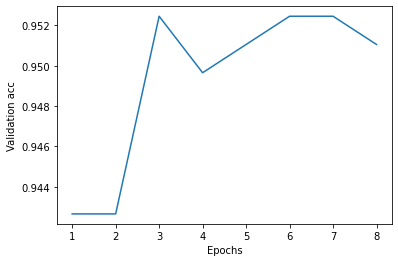

In [89]:
plt.plot(range(1, len(average_binary_accuracy_history) + 1), average_binary_accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()

!!!! Zahl epochs, wenn nötig, in dem 11. Satz anpassen !!!! 

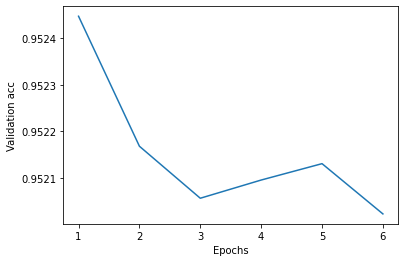

In [90]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_binary_accuracy_history = smooth_curve(average_binary_accuracy_history[2:])

plt.plot(range(1, len(smooth_binary_accuracy_history) + 1), smooth_binary_accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Validation acc')
plt.show()

Modell ausführen. !!!!!! wenn nötig, Zahl der epochs im fünften Satz korrigieren !!!!!

In [91]:
# Get a fresh, compiled model.
model = build_model()
# Train it on the entirety of the data.
model.fit(x_train, y_train,
          epochs = 2, batch_size = 1)
mess_mse_score, mess_binary_accuracy_score = model.evaluate(x_mess, y_mess)

Epoch 1/2
717/717 [==============================] - 4s 6ms/step - loss: 0.0557 - binary_accuracy: 0.9442
Epoch 2/2
9/9 [==============================] - 0s 3ms/step - loss: 0.0038 - binary_accuracy: 0.9965


In [92]:
mess_binary_accuracy_score, mess_mse_score

(0.9964664578437805, 0.0037821270525455475)

Voraussagen

In [93]:
predictions=model.predict(x_mess)
#for i in range(len(predictions)):
    #print(model.predict(x_mess))

In [94]:
print('Maximaler Wert:', max(max(model.predict(x_mess))))

Maximaler Wert: 0.8894931


Voraussgen in den aussortierten Datensätzen

In [100]:
mod_pred = model.predict(x_mess)
cutoff_value = 0.1
for i in range(len(y_mess)):
    if mod_pred[i,0]>cutoff_value:
        if ((i==0)|(mod_pred[i-1,0]>cutoff_value))|(mod_pred[i+0]>cutoff_value):
            #if df.index_string ==0:
                print (i+0,"-",
                  #i+2,"-", 
                  #y_test[i],"-", 
                  mod_pred[i],"-",
                  df.quelle[i+0],"-", 
                  df.episode[i+0],"-",
                  df.index_string[i+0],'\n')

3 - [0.8894931] - al bm_73ff - die zarentochter ging zu der quelle setzte sich unter einen baum weinte und wartete dass die lamia komme und sie fresse der heilige georg war aber in der naehe sah das maedchen einsam unter dem baume sitzen und weinen trat zu ihr und fragte sie warum sie weine das maedchen erzaehlte ihm alles der heilige georg hatte mitleid mit ihr und sagte ihr sie moege keine angst haben er wolle ihr beistehen und sie erretten da bat ihn das maedchen weinend er moege nicht fortgehen sondern bei ihr bleiben das tat er da er aber schlaefrig wurde legte er seinen kopf in ihren schoss um ein wenig zu schlafen und sagte sie solle ihn wecken sobald die lamia erscheine - 0 

90 - [0.39989597] - lappland mus_81ff - alsbald zuendete er auf dem ufer ein grosses feuer an legte als es gehoerig in brand gekommen war das ei mitten hinein und ruderte unverzueglich wieder ueber das meer zurueck sobald er ans land kam eilte er geraden weges zu dem gehoefte des riesen und sah nun dass di

Voraussage: gewünschte Datensetze abrufen

In [ ]:
#for i in range(len(x_mess)):
    #if i>30:
        #print(i+0,"-",
              #model.predict(x_mess)[i],"-",
              #df.quelle[i+0],"-",
              #df.episode[i+0],"-",
              #df.index_string[i+0],'\n')